In [2]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Necessary

- Create VE
- Create dataset

In [3]:
import sys
import os
sys.path.append(os.path.abspath("/home/gdallagl/myworkdir/ESMSec/utils"))  # Adds current folder to Python path

import utils.my_functions as mf
import utils.models as my_models
import utils.dataset as my_dataset

import torch
import random
import time
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

print(torch.__version__)

2.5.0+cu121


In [17]:
# Configuration / hyperparameters
config = {
    "FLUID": "CSF",         # Dataset name
    "NUM_EPOCHS": 10,       # Total Epochs in training
    "EVAL_EPOCH_FREQ": 2,   # Evaluation frequency
    "BATCH_SIZE": 128,       # Batch size
    "LR": 5e-5,             # Learning rate
    "LR_DECAY_GAMMA": 1,    # Learning rate decay
    "LR_DECAY_STEPS_EPOCHS": 1000, # Learning rate decay steps
    "SEED": 43215,           # Random seed
    "PROTEIN_MAX_LENGTH": 1000, # Max protein length (for ESM2)
    "PRETRAIN_ESM_CHECKPOINT_NAME": "facebook/esm2_t6_8M_UR50D", # ESM2 model name
    "PRETRAIN_ESM_CACHE_DIR": "/home/gdallagl/myworkdir/data/esm2-models", # ESM2 model cache dir
    "DATASET_PATH": "/home/gdallagl/myworkdir/ESMSec/data/protein/sec_vs_all_uniprot.csv", #"/home/gdallagl/myworkdir/ESMSec/data/protein/cyto_sec_dataset_claude.csv", # Path to dataset
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)
    "PATH_TO_SAVE_MODEL": "/home/gdallagl/myworkdir/data/ESMSec/trained_models/20000_proteins_trained_model.pth" # Path to save the model
}

# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

### Instantiate the model

In [12]:
# Load pre-trained ESM model
esm_model = AutoModel.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"],  cache_dir=config["PRETRAIN_ESM_CACHE_DIR"])
# Checj whcih model has been moded by AutoModel.from_pretrained()
print("\nESM model type", type(esm_model), "\n")

# Load relative tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ESM model type <class 'transformers.models.esm.modeling_esm.EsmModel'> 



In [13]:
# initialise model (ESM+ HEad)
net = my_models.EsmDeepSec(esm_model).to(config["DEVICE"])
# hidden dim of final embeggin of each aa after trnafoerm 
print("\nESM hidden dim", net.ESM_hidden_dim, "\n")


ESM hidden dim 320 



In [14]:
# Block ESM paramters to be trained
for param in net.esm_model.parameters():
    param.requires_grad = False

### Load dataset

In [7]:
# # Load dataset
# data = pd.read_csv(config["DATASET_PATH"])

# # Truncate sequences and add as a new column
# data['trunc_sequence'] = data['sequence'].apply(
#     lambda seq: mf.truncate_sequence(seq, max_length=config["PROTEIN_MAX_LENGTH"])
# )

# # Tokenize all sequences at once (vectorized)
# tokenized = tokenizer(
#     data['trunc_sequence'].tolist(),
#     padding='max_length',
#     max_length=config["PROTEIN_MAX_LENGTH"],
#     truncation=True,
#     return_tensors="pt"
# )

# # Add tokenized input_ids and attention_mask to DataFrame
# data['input_ids'] = list(tokenized['input_ids'])
# data['attention_mask'] = list(tokenized['attention_mask'])

# # Convert labels to tensor
# labels_tensor = torch.tensor(data['label'].values)

# # add info
# data["sequence_length"] = data['sequence'].apply(len)
# data["trunc_sequence_length"] = data['trunc_sequence'].apply(len)
# data["inputs_ids_length"] = data['input_ids'].apply(len)
# data["inputs_ids_length_no_pad"] = data.apply(
#     lambda row: (row['input_ids'] != tokenizer.pad_token_id).sum().item(), axis=1
# ) # CLS and EOS tokens are included

# ############################################

# # Split indices
# train_idx = data['set'] == 'train'
# valid_idx = data['set'] == 'validation'
# test_idx  = data['set'] == 'test'

# # Train dataset (already using custom Dataset)
# train_dataset = my_models.ProteinDataset(
#     input_ids=tokenized['input_ids'][train_idx],
#     attention_mask=tokenized['attention_mask'][train_idx],
#     labels=labels_tensor[train_idx],
#     names=data.loc[train_idx, "protein"].tolist()
# )

# # Validation dataset
# valid_dataset = my_models.ProteinDataset(
#     input_ids=tokenized['input_ids'][valid_idx],
#     attention_mask=tokenized['attention_mask'][valid_idx],
#     labels=labels_tensor[valid_idx],
#     names=data.loc[valid_idx, "protein"].tolist()
# )

# # Test dataset
# test_dataset = my_models.ProteinDataset(
#     input_ids=tokenized['input_ids'][test_idx],
#     attention_mask=tokenized['attention_mask'][test_idx],
#     labels=labels_tensor[test_idx],
#     names=data.loc[test_idx, "protein"].tolist()
# )

# # Create DataLoaders
# train_dl = DataLoader(train_dataset, batch_size=config["BATCH_SIZE"], shuffle=True, pin_memory=True)
# valid_dl = DataLoader(valid_dataset, batch_size=config["BATCH_SIZE"], shuffle=False, pin_memory=True)
# test_dl  = DataLoader(test_dataset, batch_size=config["BATCH_SIZE"], shuffle=False, pin_memory=True)


# # Optional: inspect the DataFrame
# display(data.head(5))
# print(data.loc[0, "input_ids"])

In [8]:
# Load dataset
data = pd.read_csv(config["DATASET_PATH"])

# Preprocess each sequence individually
preprocessed_data = []
for idx, row in tqdm(data.iterrows(), total=len(data)):
    processed = my_dataset.preprocess_sequence(
        sequence=row['sequence'],
        label=row['label'],
        protein_name=row['protein'],
        tokenizer=tokenizer,
        protein_max_length=config["PROTEIN_MAX_LENGTH"]
    )
    preprocessed_data.append(processed)

# Create DataFrame from preprocessed data
processed_df = pd.DataFrame(preprocessed_data)

# Add the 'set' column back from original data
processed_df['set'] = data['set'].values

############################################

train_dl = my_dataset.create_dataloader(processed_df, 'train', config["BATCH_SIZE"], shuffle=True)
valid_dl = my_dataset.create_dataloader(processed_df, 'val', config["BATCH_SIZE"], shuffle=False)
test_dl = my_dataset.create_dataloader(processed_df, 'test', config["BATCH_SIZE"], shuffle=False)

# Optional: inspect the DataFrame
display(processed_df.head(5))
print(processed_df.loc[0, "input_ids"])

100%|██████████| 20000/20000 [00:52<00:00, 378.33it/s]


sequence  \
0                                   MRWQEMGYIFYPRKLR   
1  MALHIHEACILLLVIPGLVTSAAISHEDYPADEGDQISSNDNLIFD...   
2  MNNLLCCALVFLDISIKWTTQETFPPKYLHYDEETSHQLLCDKCPP...   
3  MSLYPSLEDLKVDKVIQAQTAFSANPANPAILSEASAPIPHDGNLY...   
4  MSSRIARALALVVTLLHLTRLALSTCPAACHCPLEAPKCAPGVGLV...   

                                      trunc_sequence  \
0                                   MRWQEMGYIFYPRKLR   
1  MALHIHEACILLLVIPGLVTSAAISHEDYPADEGDQISSNDNLIFD...   
2  MNNLLCCALVFLDISIKWTTQETFPPKYLHYDEETSHQLLCDKCPP...   
3  MSLYPSLEDLKVDKVIQAQTAFSANPANPAILSEASAPIPHDGNLY...   
4  MSSRIARALALVVTLLHLTRLALSTCPAACHCPLEAPKCAPGVGLV...   

                                           input_ids  \
0  [tensor(0), tensor(20), tensor(10), tensor(22)...   
1  [tensor(0), tensor(20), tensor(5), tensor(4), ...   
2  [tensor(0), tensor(20), tensor(17), tensor(17)...   
3  [tensor(0), tensor(20), tensor(8), tensor(4), ...   
4  [tensor(0), tensor(20), tensor(8), tensor(8), ...   

                                      attention_mask  label     protein  \
0  [tensor(1), tensor(1), tensor(1), tensor(1), t...      1  A0A0C5B5G6   
1  [tensor(1), tensor(1), tensor(1), tensor(1), t...      1      B2RUY7   
2  [tensor(1), tensor(1), tensor(1), tensor(1), t...      1      O00300   
3  [tensor(1), tensor(1), tensor(1), tensor(1), t...      1      O00560   
4  [tensor(1), tensor(1), tensor(1), tensor(1), t...      1      O00622   

   sequence_length  trunc_sequence_length  inputs_ids_length  \
0               16                     16               1000   
1              222                    222               1000   
2              401                    401               1000   
3              298                    298               1000   
4              381                    381               1000   

   inputs_ids_length_no_pad    set  
0                        18  train  
1                       224  train  
2                       403  train  
3                       300  train  
4                       383  train

tensor([ 0, 20, 10, 22, 16,  9, 20,  6, 19, 12, 18, 19, 14, 10, 15,  4, 10,  2,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1, 

<Axes: ylabel='Frequency'>

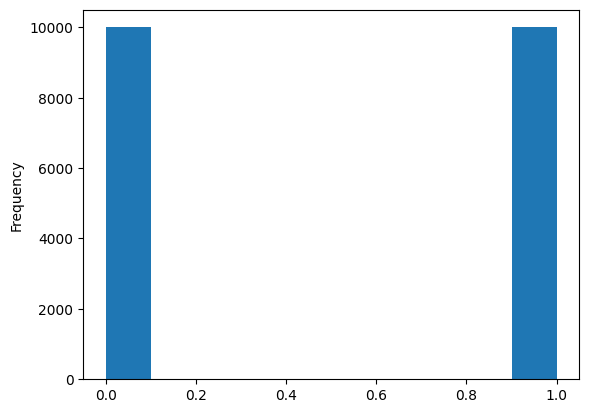

In [9]:
processed_df["label"].plot(kind='hist')

### Train

In [15]:
results = mf.train(net, train_dl, valid_dl, test_dl, config)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/501 [00:00<?, ? train batch/s]

Training:  10%|█         | 1/10 [05:09<46:21, 309.06s/epoch]

Epoch 2:   0%|          | 0/501 [00:00<?, ? train batch/s]

--- Evaluation at iteration 2 ---
	Train set: Loss: 0.1938, Acc: 92.43%, Balanced Acc: 92.43%, F1: 0.9238, MCC: 0.8486
	Validation set: Loss: 0.2067, Acc: 92.32%, Balanced Acc: 92.32%, F1: 0.9232, MCC: 0.8465


Training:  20%|██        | 2/10 [15:36<1:06:12, 496.56s/epoch]

	Test set: Loss: 0.2022, Acc: 91.67%, Balanced Acc: 91.65%, F1: 0.9147, MCC: 0.8335
Allocated memory: 0.31 GB
Cached memory:    5.83 GB


Epoch 3:   0%|          | 0/501 [00:00<?, ? train batch/s]

Training:  30%|███       | 3/10 [20:45<47:55, 410.82s/epoch]  

Epoch 4:   0%|          | 0/501 [00:00<?, ? train batch/s]

--- Evaluation at iteration 4 ---
	Train set: Loss: 0.1393, Acc: 94.65%, Balanced Acc: 94.65%, F1: 0.9455, MCC: 0.8936
	Validation set: Loss: 0.1673, Acc: 93.58%, Balanced Acc: 93.58%, F1: 0.9351, MCC: 0.8719


Training:  40%|████      | 4/10 [31:13<49:39, 496.58s/epoch]

	Test set: Loss: 0.1620, Acc: 93.48%, Balanced Acc: 93.46%, F1: 0.9325, MCC: 0.8705
Allocated memory: 0.31 GB
Cached memory:    5.83 GB


Epoch 5:   0%|          | 0/501 [00:00<?, ? train batch/s]

Training:  50%|█████     | 5/10 [36:22<35:44, 428.81s/epoch]

Epoch 6:   0%|          | 0/501 [00:00<?, ? train batch/s]

--- Evaluation at iteration 6 ---
	Train set: Loss: 0.1086, Acc: 96.23%, Balanced Acc: 96.22%, F1: 0.9631, MCC: 0.9255
	Validation set: Loss: 0.1775, Acc: 93.43%, Balanced Acc: 93.41%, F1: 0.9367, MCC: 0.8706


Training:  60%|██████    | 6/10 [46:49<33:05, 496.39s/epoch]

	Test set: Loss: 0.1613, Acc: 93.99%, Balanced Acc: 94.03%, F1: 0.9411, MCC: 0.8818
Allocated memory: 0.31 GB
Cached memory:    5.83 GB


Epoch 7:   0%|          | 0/501 [00:00<?, ? train batch/s]

Training:  70%|███████   | 7/10 [51:58<21:44, 434.97s/epoch]

Epoch 8:   0%|          | 0/501 [00:00<?, ? train batch/s]

--- Evaluation at iteration 8 ---
	Train set: Loss: 0.0817, Acc: 97.02%, Balanced Acc: 97.02%, F1: 0.9710, MCC: 0.9416
	Validation set: Loss: 0.1895, Acc: 93.38%, Balanced Acc: 93.36%, F1: 0.9368, MCC: 0.8709


Training:  80%|████████  | 8/10 [1:02:25<16:32, 496.18s/epoch]

	Test set: Loss: 0.1725, Acc: 94.24%, Balanced Acc: 94.29%, F1: 0.9438, MCC: 0.8874
Allocated memory: 0.31 GB
Cached memory:    5.83 GB


Epoch 9:   0%|          | 0/501 [00:00<?, ? train batch/s]

Training:  90%|█████████ | 9/10 [1:07:34<07:17, 437.51s/epoch]

Epoch 10:   0%|          | 0/501 [00:00<?, ? train batch/s]

--- Evaluation at iteration 10 ---
	Train set: Loss: 0.0235, Acc: 99.48%, Balanced Acc: 99.48%, F1: 0.9948, MCC: 0.9896
	Validation set: Loss: 0.1317, Acc: 95.48%, Balanced Acc: 95.48%, F1: 0.9554, MCC: 0.9098


Training: 100%|██████████| 10/10 [1:18:02<00:00, 468.21s/epoch]

	Test set: Loss: 0.1333, Acc: 95.40%, Balanced Acc: 95.41%, F1: 0.9539, MCC: 0.9083
Allocated memory: 0.31 GB
Cached memory:    5.83 GB


### Plot


=== Final Evaluation Metrics ===
Train   -> Loss: 0.0235, Accuracy: 99.48%
Valid   -> Loss: 0.1317, Accuracy: 95.48%
Test    -> Loss: 0.1333, Accuracy: 95.40%


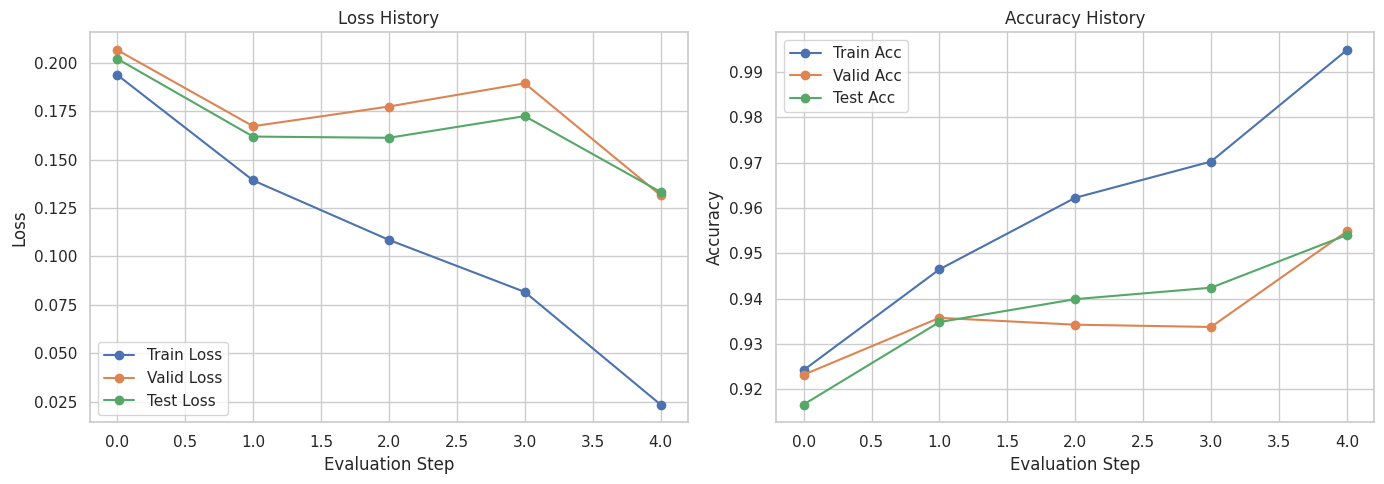

In [16]:
mf.summarize_training(*results)

### Save Model

In [18]:
torch.save(net, config["PATH_TO_SAVE_MODEL"])

### Load Model

In [ ]:
model = torch.load(config["PATH_TO_SAVE_MODEL"])
model.to(config["DEVICE"])
model.eval()

### Umaps

Many types of embeddings can be extracted from different moments inside the model:

**1. From the ESM backbone**
- **ESM mean** → mean pooling over all token embeddings.  
- **ESM max** → max pooling over all token embeddings.  
- **ESM CLS** → embedding of the special classification token (first position).  
- **ESM tokens** → full sequence of token-level embeddings `[batch, seq_len, hidden_dim]`.  
- (Optional) **Layerwise embeddings** → extracting hidden states from multiple layers (e.g. last 4).

**2. From the feature head (AttentionClassificationHead)**
- **Feature mean** → mean pooling after attention + FFNN.  
- **Feature max** → max pooling after attention + FFNN.  
- **Feature CLS** → CLS token representation after attention + FFNN.  
- **Feature concat** → concatenation of mean and max pooling (used for classification).  


Extracting embeddings from training set...



Batch:   0%|          | 0/501 [00:00<?, ? train batch/s]

esm_mean: (16027, 320)
esm_cls: (16027, 320)
feature_mean: (16027, 320)
feature_max: (16027, 320)
feature_cls: (16027, 320)
feature_concat: (16027, 640)

Computing UMAP embeddings...

Computing UMAP for esm_mean with shape (16027, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for esm_cls with shape (16027, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_mean with shape (16027, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_max with shape (16027, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_cls with shape (16027, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_concat with shape (16027, 640)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Plotting UMAP embeddings...



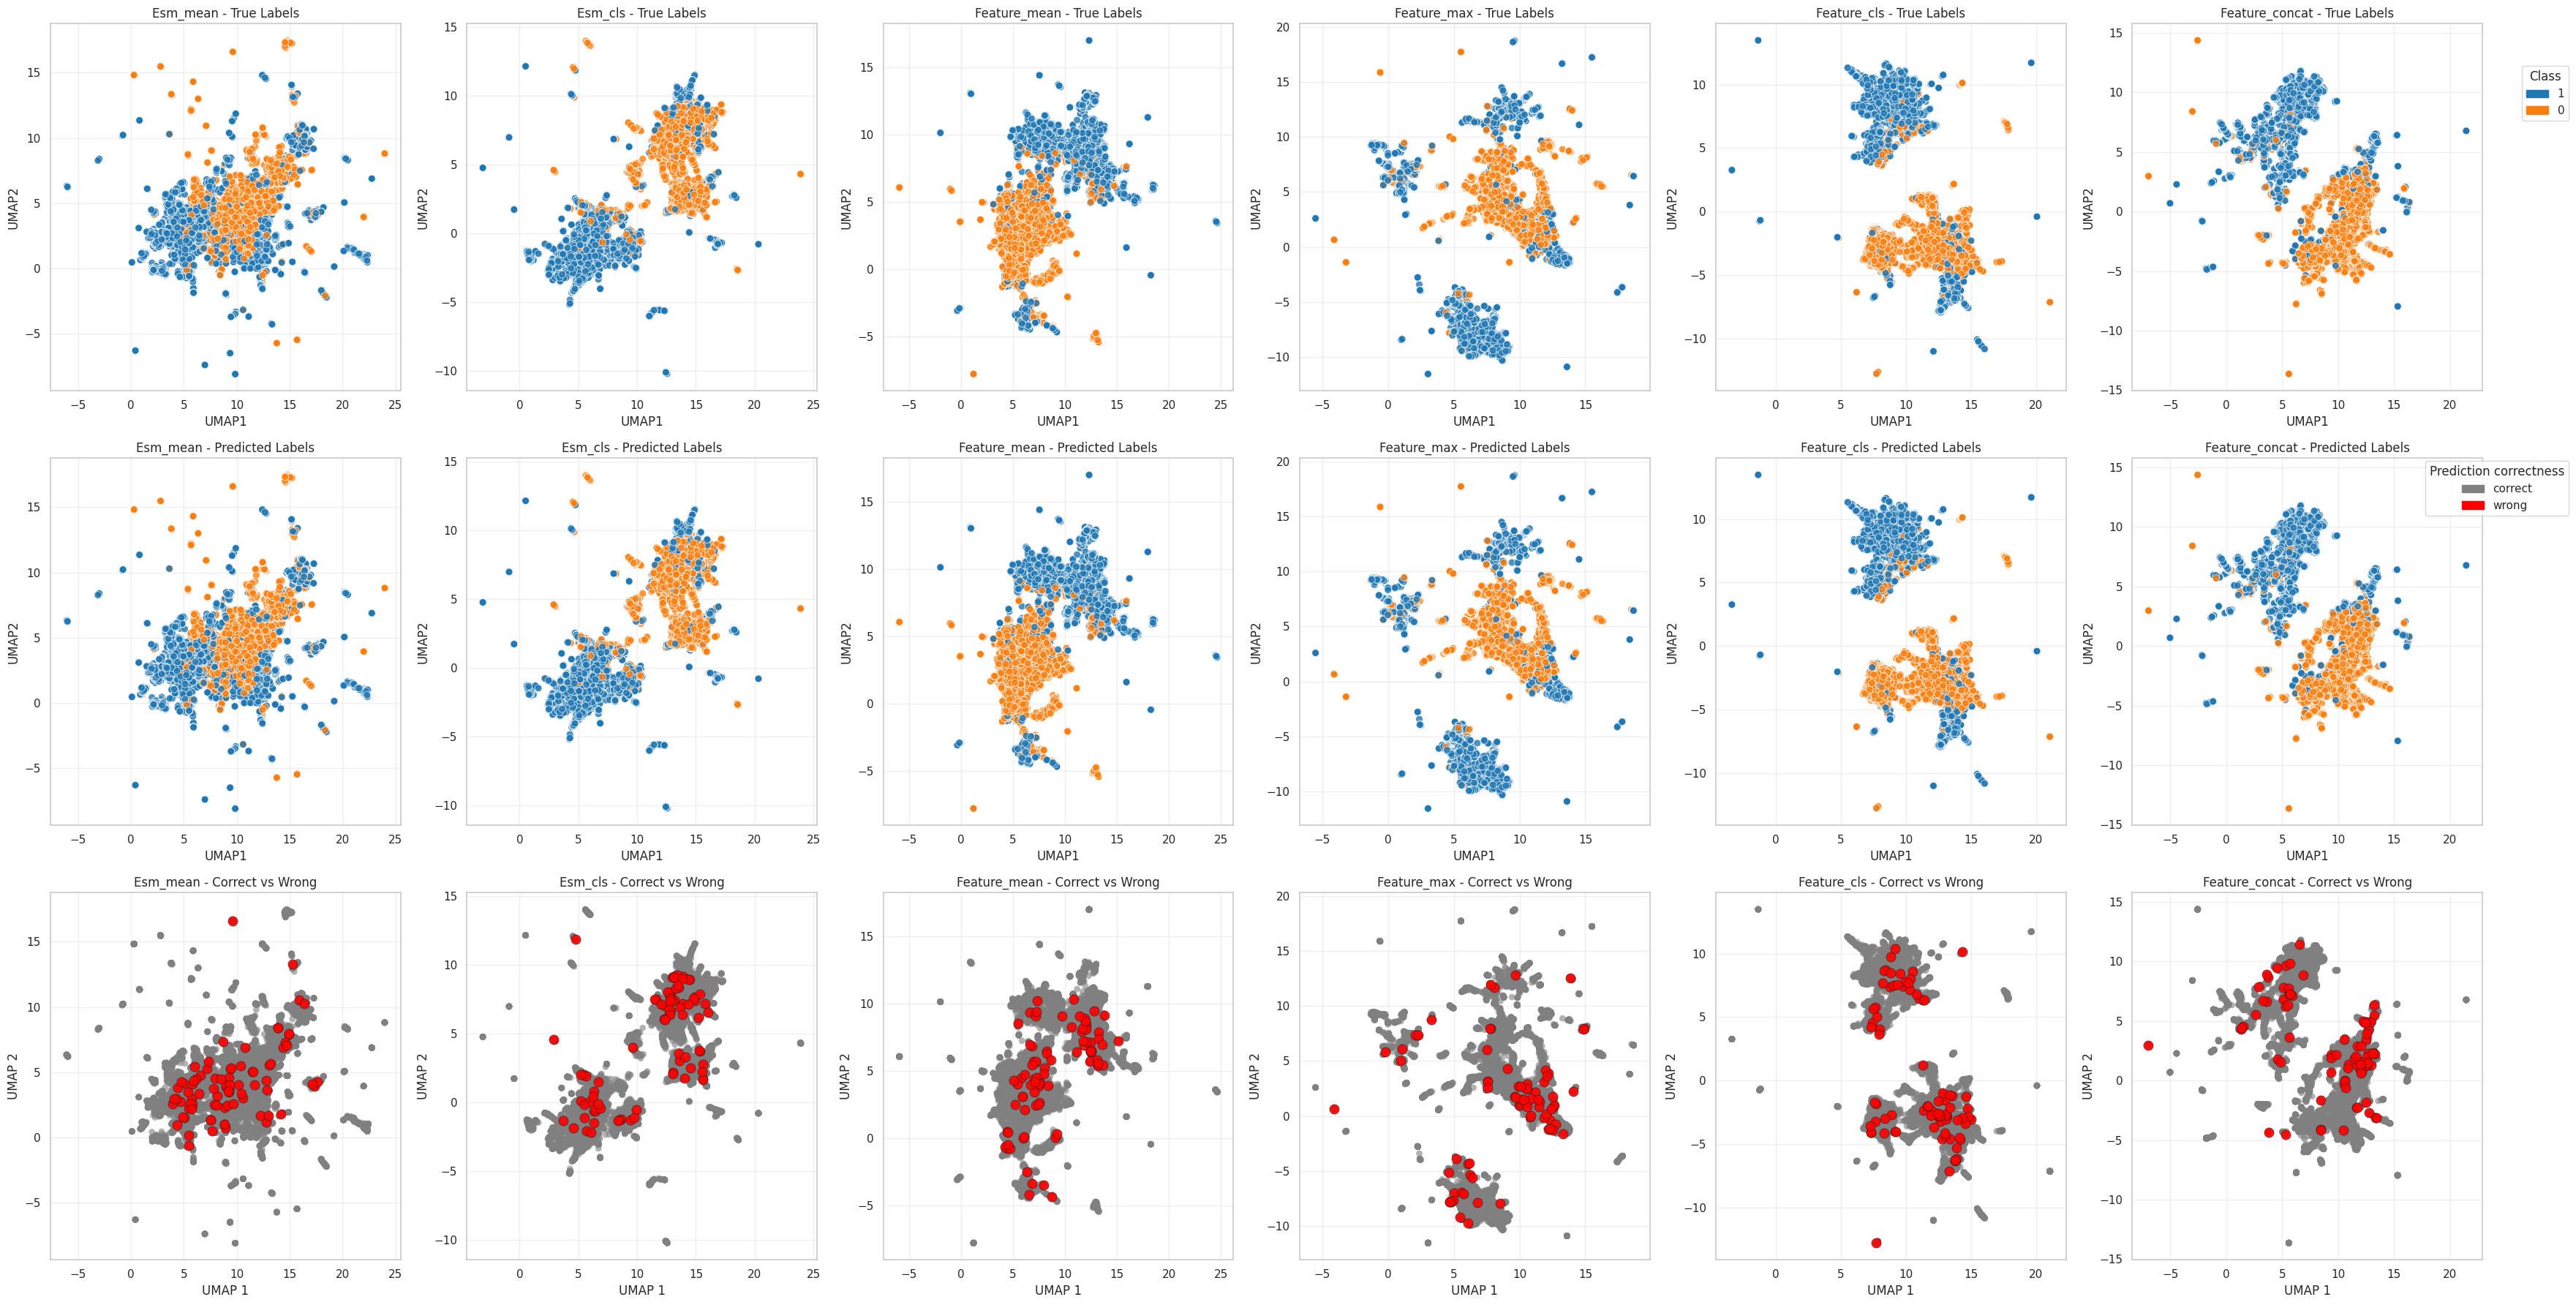

Name      UMAP1      UMAP2 TrueClass PredClass CorrectStr
0      Q7T3J2   8.080933  10.573062         1         1    correct
1      P05111   5.620412   9.302125         1         1    correct
2      P49662   8.412817  -6.688470         1         1    correct
3      P47710   5.186032   9.524931         1         1    correct
4      P81297   6.131886   5.861276         1         1    correct
...       ...        ...        ...       ...       ...        ...
16022  Q92769   7.761452  -3.844963         0         0    correct
16023  P78333   5.628906   7.893986         1         1    correct
16024  P0DJ50   8.202971  10.854073         1         1    correct
16025  O60928   8.019252   0.670361         0         0    correct
16026  Q8IW40  11.946820   1.870366         0         0    correct

[16027 rows x 6 columns]

In [22]:
DATALOADER = train_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Choose which embeddings you want to extract
which_embeddings = [
    "esm_mean",       # mean pooled ESM embeddings
    "esm_cls",        # CLS token embedding from ESM
    "feature_mean",   # mean pooled feature_fn embeddings
    "feature_max",    # max pooled feature_fn embeddings
    "feature_cls",    # CLS token from feature_fn
    "feature_concat"  # concatenated mean||max for classifier input
]

# Extract embeddings
train_embeddings, names, labels, predictions = mf.extract_embeddings(
    net=net,
    dl=train_dl,
    device=config["DEVICE"],
    which=which_embeddings,
    cls_index=0,      # index of CLS token in sequence
    return_numpy=True # set to False if you want torch tensors instead
)

# Example: check shapes
for key, emb in train_embeddings.items():
    print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = mf.compute_umap_tensors(
    embeddings_dict=train_embeddings,
)

# Access UMAP DataFrame for feature_mean embeddings
df_feature_mean = umap_tensors['feature_mean']

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

mf.plot_umap_embeddings(umap_tensors, names, labels, predictions, embedding_keys=which_embeddings)

Batch:   0%|          | 0/62 [00:00<?, ? train batch/s]

esm_mean: (1980, 320)
esm_cls: (1980, 320)
feature_mean: (1980, 320)
feature_max: (1980, 320)
feature_cls: (1980, 320)
feature_concat: (1980, 640)
Computing UMAP for esm_mean with shape (1980, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for esm_cls with shape (1980, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_mean with shape (1980, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_max with shape (1980, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_cls with shape (1980, 320)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP for feature_concat with shape (1980, 640)...


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


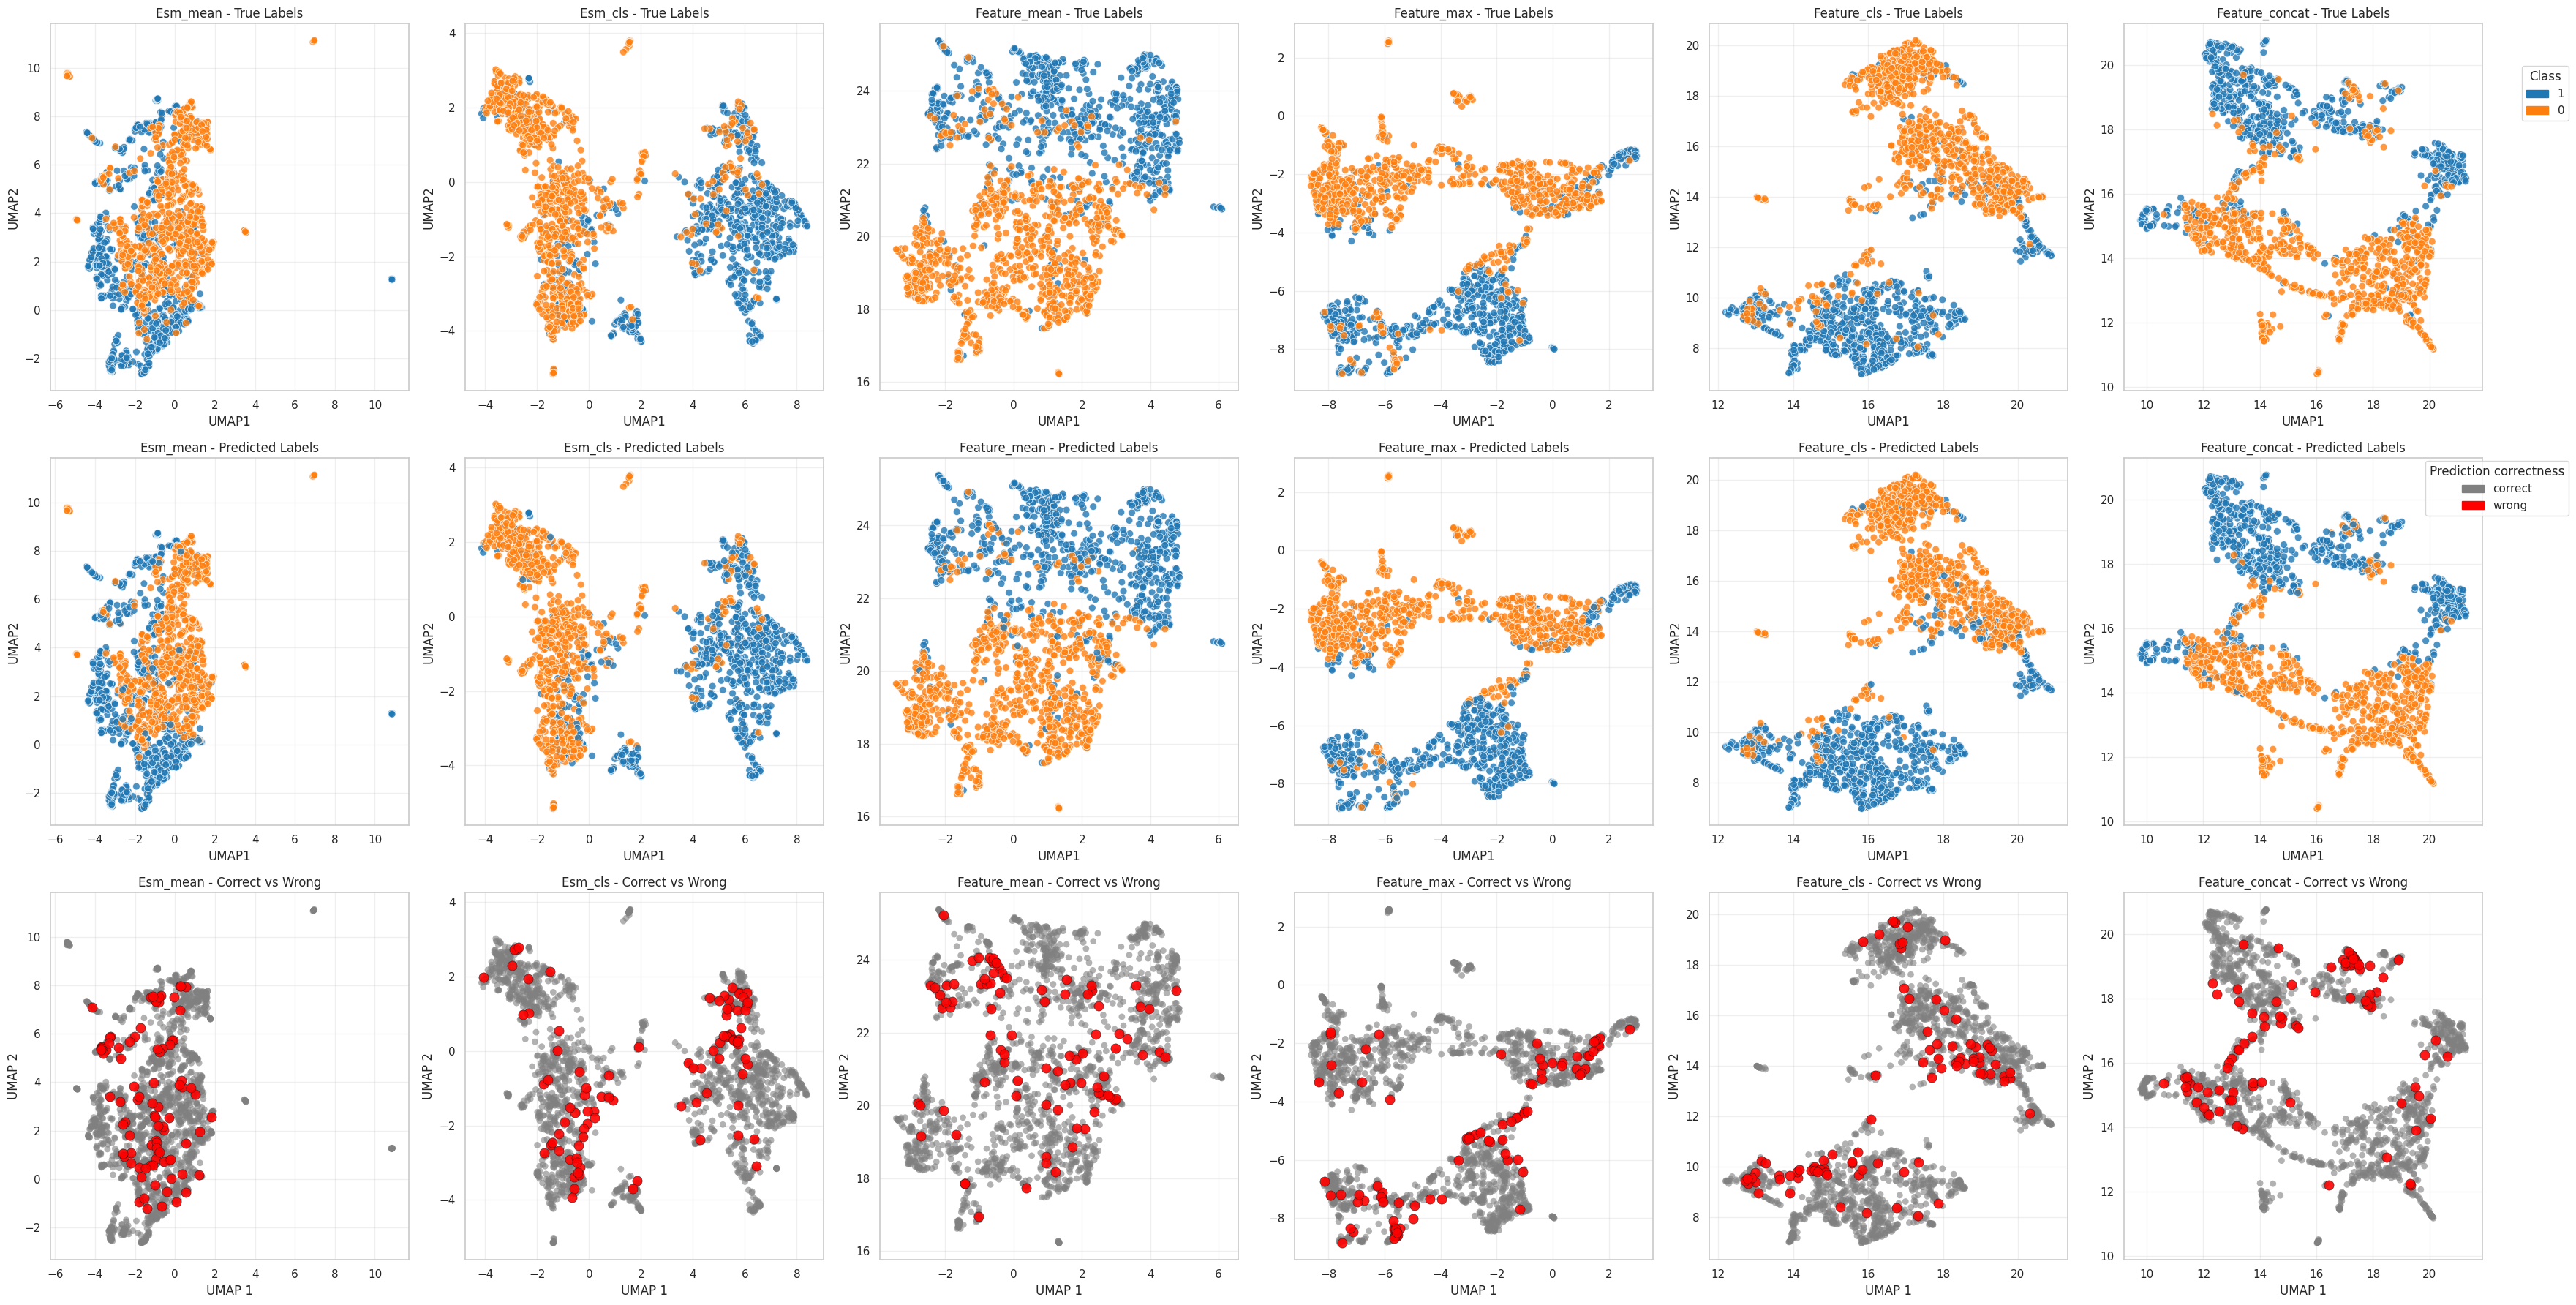

In [23]:
DATALOADER = test_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

# Choose which embeddings you want to extract
which_embeddings = [
    "esm_mean",       # mean pooled ESM embeddings
    "esm_cls",        # CLS token embedding from ESM
    "feature_mean",   # mean pooled feature_fn embeddings
    "feature_max",    # max pooled feature_fn embeddings
    "feature_cls",    # CLS token from feature_fn
    "feature_concat"  # concatenated mean||max for classifier input
]

# Extract embeddings
train_embeddings, names, labels, predictions = mf.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    which=which_embeddings,
    cls_index=0,      # index of CLS token in sequence
    return_numpy=True # set to False if you want torch tensors instead
)

# Example: check shapes
for key, emb in train_embeddings.items():
    print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

umap_tensors = mf.compute_umap_tensors(
    embeddings_dict=train_embeddings,
)

# Access UMAP DataFrame for feature_mean embeddings
df_feature_mean = umap_tensors['feature_mean']

#############################
###### PLOT
#############################

df = mf.plot_umap_embeddings(umap_tensors, names, labels, predictions, embedding_keys=which_embeddings)

In [30]:
df

df[df['CorrectStr'] == 'wrong']
df[df['CorrectStr'] != 'wrong'].head(20)


Name      UMAP1      UMAP2 TrueClass PredClass CorrectStr
0   P01579  14.047040  18.776281         1         1    correct
2   P02743  20.902557  16.701103         1         1    correct
3   P05451  18.435154  19.407917         1         1    correct
4   P07492  13.228580  19.008860         1         1    correct
5   P09544  13.608293  18.158689         1         1    correct
6   P14920  20.016661  14.961930         1         1    correct
8   P20851  16.909853  18.931675         1         1    correct
9   P21128  15.912220  18.581226         1         1    correct
10  P22105  17.304070  18.005573         1         1    correct
11  P23083  17.054081  19.547197         1         1    correct
12  P56851  13.498884  18.681652         1         1    correct
13  P60022  12.352859  20.089808         1         1    correct
14  Q12794  14.800017  17.998049         1         1    correct
15  Q12836  14.211823  17.568319         1         1    correct
16  Q13275  17.738413  17.956488         1         1    correct
17  Q76M96  15.245771  17.150957         1         1    correct
18  Q9UBH0  11.038093  15.019709         1         1    correct
19  Q9Y5C1  14.407063  18.042795         1         1    correct
20  Q9Y5L2  10.776967  15.607558         1         1    correct
21  P01031  17.614853  17.755106         1         1    correct

### A-scanning

In [37]:
PROTEIN = "O60938" #"Q6ZRI0" #"P01270" #"O60938" #"P05997"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length

# Extract info
single_protein_info = processed_df[processed_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

# Run alanine scanning
results = mf.alanine_scanning(
    model=net,
    tokenizer=tokenizer,
    single_protein_info=single_protein_info,
    window_size=WINDOW_SIZE_SUBSTITUION, # make it odd
    device=config["DEVICE"],
    SUBSTITUTE_AA="A",#"<pad>"
    normalise_true_substitution=True #normalise by number of true substitutions (not A->A
)

sequence                    MAGTICFIMWVLFITDTVWSRSVRQVYEVHDSDDWTIHDFECPMEC...
trunc_sequence              MAGTICFIMWVLFITDTVWSRSVRQVYEVHDSDDWTIHDFECPMEC...
input_ids                   [tensor(0), tensor(20), tensor(5), tensor(6), ...
attention_mask              [tensor(1), tensor(1), tensor(1), tensor(1), t...
label                                                                       1
protein                                                                O60938
sequence_length                                                           352
trunc_sequence_length                                                     352
inputs_ids_length                                                        1000
inputs_ids_length_no_pad                                                  354
set                                                                       val
Name: 24, dtype: object

3


Evaluation:   0%|          | 0/1 [00:00<?, ? Single protein batch/s]

Generating mutations:   0%|          | 0/352 [00:00<?, ?it/s]

Preprocessing mutations:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating model on mutated sequences...


Evaluation:   0%|          | 0/118 [00:00<?, ? Batch Mutation Scan batch/s]

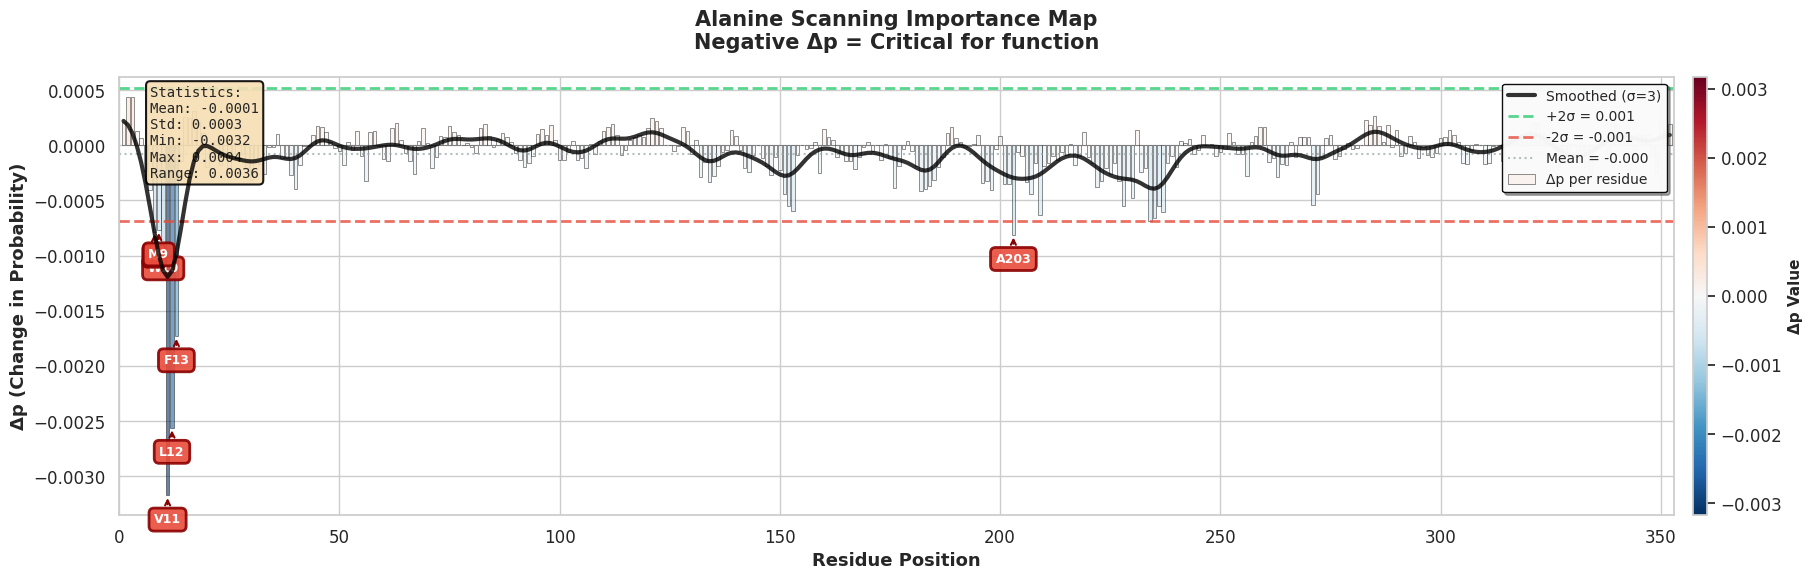


                       ALANINE SCANNING SUMMARY                       

Sequence Information:         
  Length:                   352
  Protein:                  O60938

Statistical Summary:          
  Mean Δp:                  -0.0001
  Std Δp:                   0.0003
  Min Δp:                   -0.0032
  Max Δp:                   0.0004
  Threshold (+2σ):          0.0005
  Threshold (-2σ):          -0.0007

──────────────────────────────────────────────────────────────────────
             TOP CRITICAL RESIDUES (Largest Negative Δp)              
──────────────────────────────────────────────────────────────────────
Rank    Position    Residue     Δp             Status              
──────────────────────────────────────────────────────────────────────
1       11          V           -0.0032        ⚠️  Beyond threshold
2       12          L           -0.0026        ⚠️  Beyond threshold
3       13          F           -0.0017        ⚠️  Beyond threshold
4       10          W      

In [38]:
#ploitting

mf.plot_alanine_scan(
    delta_p=results['delta_probs'],
    sequence=results['sequence'],
    protein_name=results['protein_name'],
    sigma=3,
    threshold=True,
    highlight_residues=True,
    top_n=10,
    show_sequence=False,
    style='whitegrid'  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
)